## 노래의 특징(댄스 가능성, 라이브성, 음량, 에너지)을 바탕으로 노래가 히트할지 안할지 예측한다

- 데이터 전처리, 머신러닝 (모델 선택), 시각화
- 회귀: 수치예측
- 앙상블: 여러 모델들을 혼합해 사용
- GridSearch: 하이퍼파라미터 자동 최적화
   
   데이터셋: https://www.kaggle.com/datasets/yasserh/song-popularity-dataset?resource=download
   
1. 데이터 불러오기
2. 데이터 분석 (EDA)
3. 데이터 전처리
4. 인기 예측 회귀 모델
5. 성능 분석
6. 회귀 모델 고도화


In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl        # 시각화도구 (시각화 옵션, 폰트설정)
import matplotlib.pyplot as plt # 데이터 시각화용 도구
import seaborn as sns           # 데이터 시각화용 도구

# 폰트 및 마이너스 깨짐 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 노래 데이터 가져오기
df = pd.read_csv('./data/song_data.csv', encoding='utf-8')

target = 'song_popularity' # 노래의 인기점수


### 종속변수
|특성명|설명|범위/값|
|------|----|------|
|song_popularity|인기점수|(0점 ~ 100점)|

### 특징(독립 변수)
|특성명|설명|범위/값|
|------|----|------|
|song_duration_ms|노래길이|(밀리초 단위)|
|acousticness|어쿠스틱 노래 가능성|(0 ~ 1)|
|danceability|댄스 가능성이 높은 노래|(0 ~ 0.99)|
|energy|노래의 에너지 강도|(0 ~ 1.0)|
|instrumentalness|노래에 보컬이 없을 가능성|(0~1.0)|
|key|음악 키|(0 = C, 11 = B, 0~11)|
|liveness|라이브 관객의 존재 추정|(0.01~0.99)|
|loudness|음량 래벨|(-38.8~1.58)|
|audio_mode|조|(1: 장조, 0: 단조)|
|speechiness|발화된 단어가 존재할 가능성|(0.0~0.99)|
|tempo|분당박자|(BPM)|
|time_signature|음악 한 마디의 박자|(0~5)|
|audio_valence|트랙의 긍정성 또는 쾌활함|(0.0~0.98)|


In [2]:
df.drop("song_name", axis=1, inplace=True) # sone_name열은 사용하지 않아 삭제한다.

In [3]:
df.columns

Index(['song_popularity', 'song_duration_ms', 'acousticness', 'danceability',
       'energy', 'instrumentalness', 'key', 'liveness', 'loudness',
       'audio_mode', 'speechiness', 'tempo', 'time_signature',
       'audio_valence'],
      dtype='object')

In [4]:
features = [i for i in df.columns if i not in [target]] # 특성 필터링
original_df = df.copy(deep=True) # 데이터 원본 보존 깊은 복사
df.shape

print(f"이 데이터 셋에는 {df.shape[1]}개의 특성과 {df.shape[0]}개의 샘플로 구성되어 있다.")

이 데이터 셋에는 14개의 특성과 18835개의 샘플로 구성되어 있다.


# 탐색적 데이터 분석 (EDA)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   18835 non-null  int64  
 1   song_duration_ms  18835 non-null  int64  
 2   acousticness      18835 non-null  float64
 3   danceability      18835 non-null  float64
 4   energy            18835 non-null  float64
 5   instrumentalness  18835 non-null  float64
 6   key               18835 non-null  int64  
 7   liveness          18835 non-null  float64
 8   loudness          18835 non-null  float64
 9   audio_mode        18835 non-null  int64  
 10  speechiness       18835 non-null  float64
 11  tempo             18835 non-null  float64
 12  time_signature    18835 non-null  int64  
 13  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5)
memory usage: 2.0 MB


In [6]:
# 숫자형, 범주형 특징 식별
nu = df[features].nunique().sort_values() # 각 특성별로 고유값(카테고리) 갯수 계산 후 정렬
nf = [] # 숫자형 특성 리스트
cf = [] # 범주형 특성 리스트
nnf = 0 # 숫자형 특성 갯수
ncf = 0 # 범주형 특성 갯수


for i in range(df[features].shape[1]):
    # 16개 미만의 값을 가진 특징은 범주형으로 간주한다.
    if nu.values[i] <= 16:
        cf.append(nu.index[i])
    else:
        nf.append(nu.index[i])

print(f"이 데이터셋은 {len(nf)}개의 숫자형 특성과 {len(cf)}개의 범주형 특성을 가진 데이터셋입니다.")
print(f"범주형 틁성: {cf}")
print(f"숫자형 틁성: {nf}")

이 데이터셋은 10개의 숫자형 특성과 3개의 범주형 특성을 가진 데이터셋입니다.
범주형 틁성: ['audio_mode', 'time_signature', 'key']
숫자형 틁성: ['danceability', 'energy', 'speechiness', 'audio_valence', 'liveness', 'acousticness', 'instrumentalness', 'loudness', 'song_duration_ms', 'tempo']


In [7]:
df['song_popularity']

0        73
1        66
2        76
3        74
4        56
         ..
18830    60
18831    60
18832    23
18833    55
18834    60
Name: song_popularity, Length: 18835, dtype: int64

In [8]:
df.isnull().sum() # 결측치 확인

song_popularity     0
song_duration_ms    0
acousticness        0
danceability        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
audio_mode          0
speechiness         0
tempo               0
time_signature      0
audio_valence       0
dtype: int64

In [9]:
df[nf].describe().T # 통계량을 행이 아닌 컬럼별로 한줄씩 보이게 한다.

,count,mean,std,min,25%,50%,75%,max
danceability,18835.0,0.633348,0.156723,0.000000,0.5330,0.645000,0.74800,0.987
energy,18835.0,0.644995,0.214101,0.001070,0.5100,0.674000,0.81500,0.999
speechiness,18835.0,0.102099,0.104378,0.000000,0.0378,0.055500,0.11900,0.941
audio_valence,18835.0,0.527967,0.244632,0.000000,0.3350,0.527000,0.72500,0.984
liveness,18835.0,0.179650,0.143984,0.010900,0.0929,0.122000,0.22100,0.986
acousticness,18835.0,0.258539,0.288719,0.000001,0.0241,0.132000,0.42400,0.996
instrumentalness,18835.0,0.078008,0.221591,0.000000,0.0000,0.000011,0.00257,0.997
loudness,18835.0,-7.447435,3.827831,-38.768000,-9.0440,-6.555000,-4.90800,1.585
song_duration_ms,18835.0,218211.587576,59887.540566,12000.000000,184339.5000,211306.000000,242844.00000,1799346.000
tempo,18835.0,121.073154,28.714456,0.000000,98.3680,120.013000,139.93100,242.318


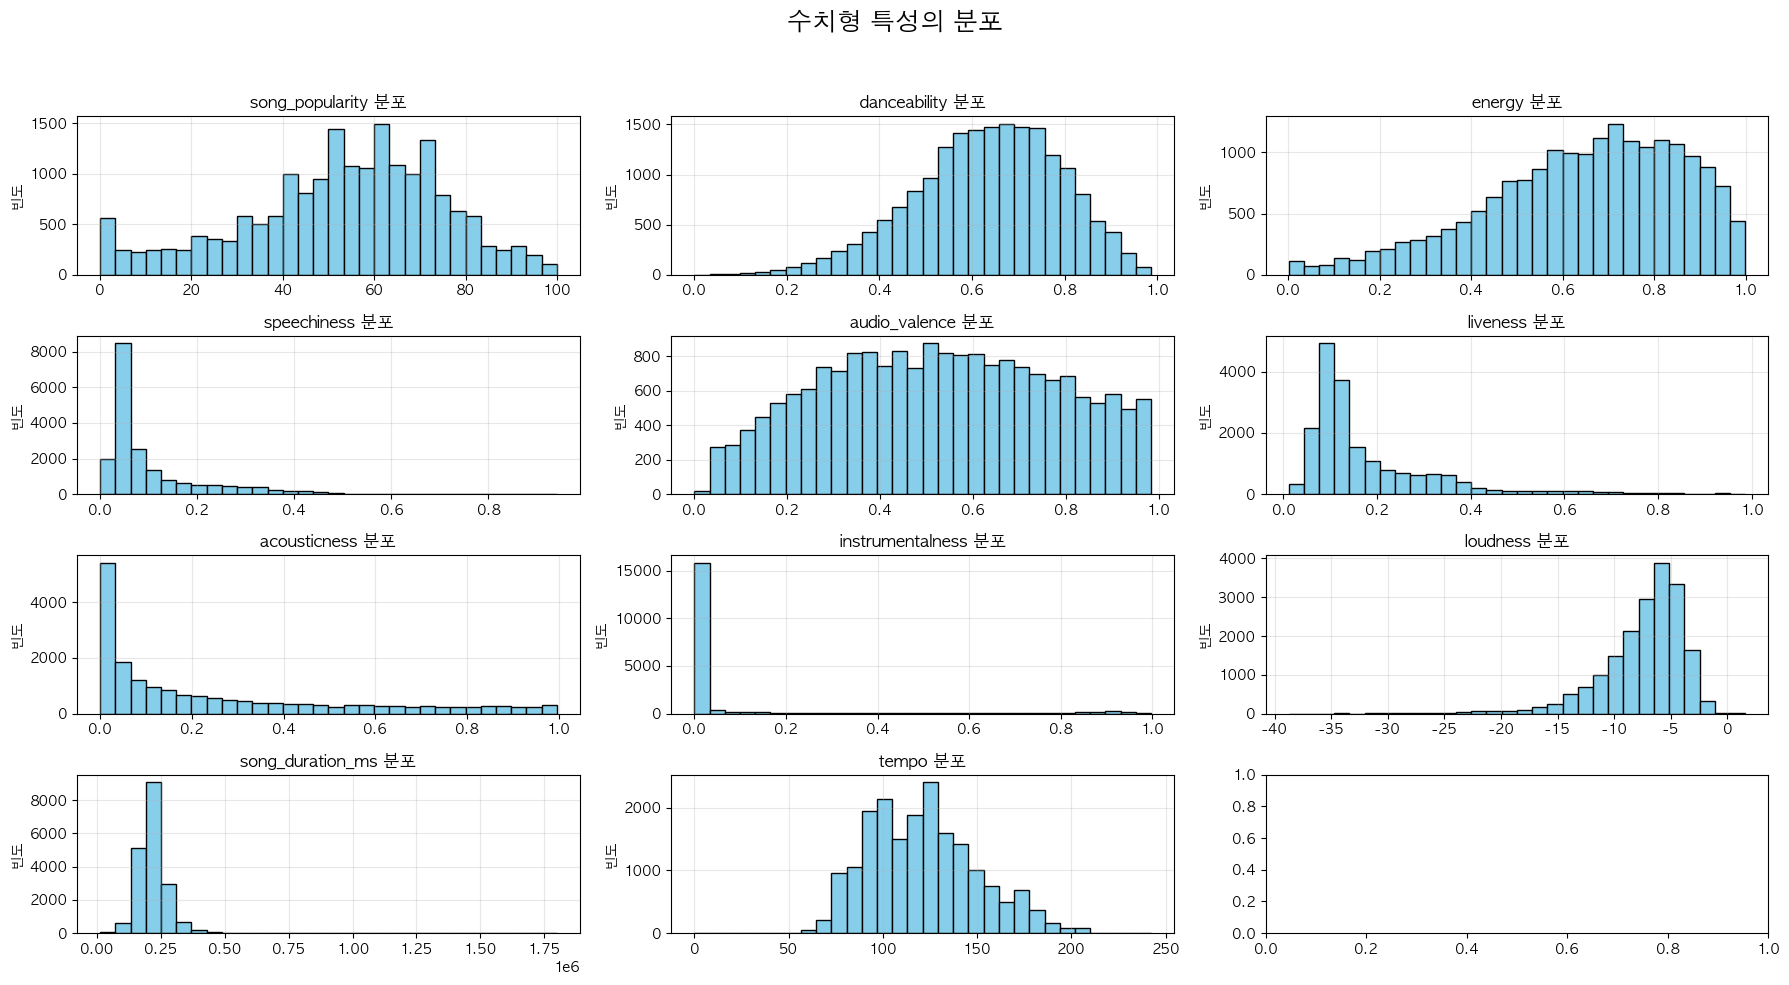

In [10]:
# 수치형 변수의 분포
columns = [target] + nf # 타겟(인기도)와 숫자형 특성들 리스트

fig, axes = plt.subplots(4, 3, figsize=(18, 10)) # 4행 3열의 서브플롯 그래프 생성
for idx, col in enumerate(columns):
    row = idx // 3        # 몇번째 행에 그릴지 결정
    col_idx = idx % 3     # 몇번째 열에 그릴지 결정
    axes[row][col_idx].hist( # 히스토그램
        df[col].dropna(),    # 데이터는 해당 컬럼
        bins=30,             # 구간은 30
        color='skyblue',       # 색 지정
        edgecolor='black'    # 테두리는 검정
        )
    axes[row][col_idx].set_title(f"{col} 분포")
    
    axes[row][col_idx].set_ylabel("빈도")
    axes[row][col_idx].grid(alpha=0.3)            # 격자(그리드) 표시, 투명도 0.3
    
plt.suptitle("수치형 특성의 분포", fontsize=18)        # 그래프의 전체제목 설정
plt.tight_layout(rect=[0, 0, 1, 0.95])            # 그래프 간격 조정
plt.show()


- 우측이나 좌측으로 많이 쏠린 (왜도) 컬럼들은 로그변환들이 필요할 수 있다. 이를 통해 전규 분포 (가우시안 분포)에 가깝게 만들 수 있다.

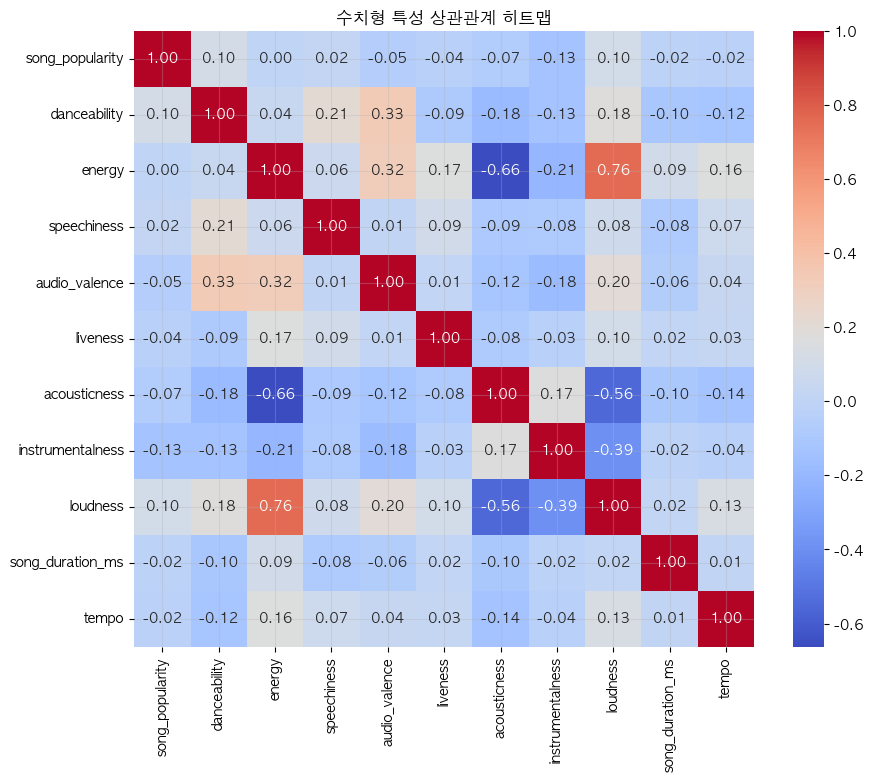

In [11]:
# 수치형 특성간 상관관계 매트릭스
plt.figure(figsize=(10, 8))
corr_matrix = df[[target] + nf].corr(numeric_only=True) # 수치형 변수들만 상관관계 계산
sns.heatmap(
    corr_matrix,       # 상관관계 데이터
    annot=True,        # 내부값 표시
    cmap='coolwarm',   # 값 형태(소수점 2자리)
    fmt='.2f'          # 컬러맵 설정
) # 히트맵 시각화

plt.title("수치형 특성 상관관계 히트맵")
plt.grid(alpha=0.3)   # 투명도 30% 격자
plt.show()

- 수치형 변수들 확인 결과 목표 변수인 song_popularity와 매우 낮은 상관관계를 보이는 것을 확인.
- 일부 변수간의 상관관계가 오히려 더 있어보인다.
- (예) energy - loudness
=> 다중공선성이 존재할 수 있다.
- 만약 컬럼간의 중복성이 있다면 하나의 컬럼을 삭제하는것도 고려해봐야 한다.
   
- 다중공선성(특정 변수들간의 중복성) 확인하기 위해 VIF(Variance Inflation Factor)를 사용한다.
- VIF가 5 이상이면 다중공선성이 있고 강한 상관관계를 가졌다고 판단한다.

In [12]:
nf

['danceability',
 'energy',
 'speechiness',
 'audio_valence',
 'liveness',
 'acousticness',
 'instrumentalness',
 'loudness',
 'song_duration_ms',
 'tempo']

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant # 상수항(절편) 추가시에 사용

checking_columns = ['instrumentalness', 'energy', 'loudness', 'acousticness', 'audio_valence'] # VIF를 확인할 변수 목록
vif_df = df[checking_columns].copy()
vif_df = vif_df.dropna()

vif_data = add_constant(vif_df)        # 상수항(절편) 추가
# vif_data

vif = pd.DataFrame()
vif["feature"] = vif_data.columns
#vif
vif['VIF'] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])] # 각 변수별 VIF 계산
vif = vif[vif["feature"] != "const"] # 상수항 제외

### 1에 가까운 2개의 컬럼은 중복성이 매우 낮다.
### 그 외 3개의 컬럼은 어느정도 중복성이 있어 보인다.
### 그러나 5를 넘지 않았기 때문에 삭제를 고려할 정도의 수준은 아니다.

/var/folders/51/k_yn4qxs0_nfrm1hk39_0m2r0000gn/T/ipykernel_31944/1350290794.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="audio_mode", y="song_popularity", data=df, palette="Set2")


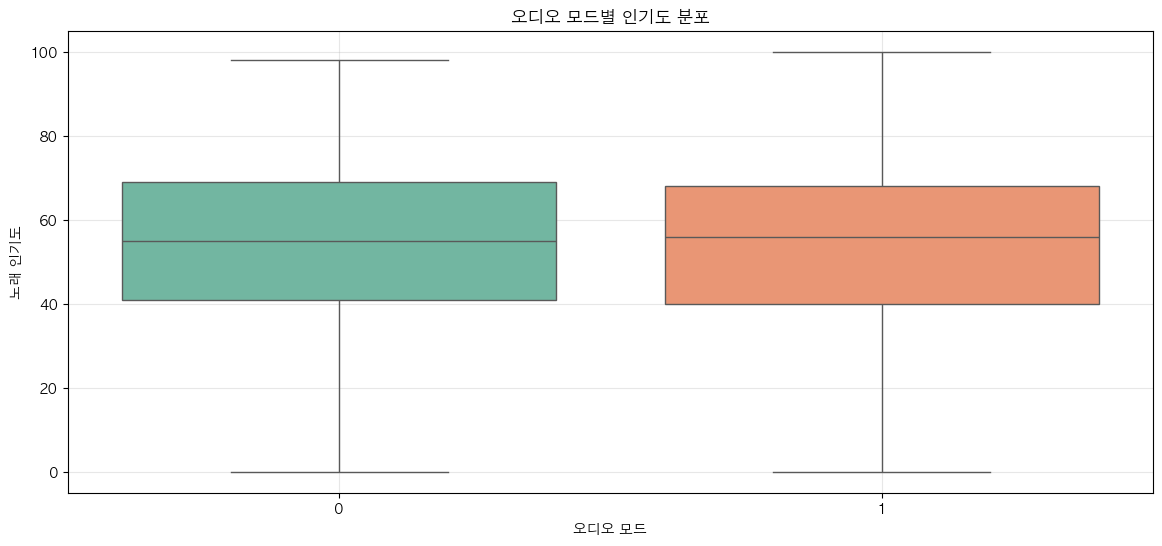

In [14]:
# 범주형 변수의 값에 따른 song_popularity의 관계 확인
plt.figure(figsize=(14, 6))
sns.boxplot(x="audio_mode", y="song_popularity", data=df, palette="Set2")
plt.title("오디오 모드별 인기도 분포")
plt.xlabel("오디오 모드")
plt.ylabel("노래 인기도")
plt.grid(alpha=0.3)
plt.show()

### 범주형 변수들은 개별적으로는 뚜렷한 패턴은 없었다.

### 데이터 전처리
- 결측값 처리 : 결측값은 없었다.
- 이상치 : IQR 방식으로 탐지하여 제거한다.
- 특성 정규화 : 왜도가 있는 수치형 변수(speechiness, liveness, acousticness, instrumentalness)에 대해 정규화 적용해서 정규 분포에 가깝게 만들어준다.
- 범주형 변수 인코딩 : 모두 숫자이므로 인코딩 안해도 된다.

In [15]:
# 이상치 데이터 샘플링
df1 = df.copy()

feature1 = nf + ["song_popularity"] # 숫자형 특성과 타겟 변수 포함

for i in feature1:
    Q1 = df1[i].quantile(0.25)  # 1사분위수(25%)
    Q3 = df1[i].quantile(0.75)  # 3사분위수(75%
    IQR = Q3 - Q1

    df1 = df1[df1[i] <= (Q3 + (1.5 * IQR))] # 이상치 상한선(3사분위수 + 1.5 * IQR) 초과 샘플 제거
    df1 = df1[df1[i] >= (Q1 - (1.5 * IQR))] # 이상치 하한선(1사분위수 - 1.5 * IQR) 미만 샘플 제거
    df1 = df1.reset_index(drop=True)        # 인덱스 재설정

print(f"이상치 제거 전 데이터 수 : {df.shape[0]}")
print(f"이상치 제거 후 데이터 수 : {df1.shape[0]}")

이상치 제거 전 데이터 수 : 18835
이상치 제거 후 데이터 수 : 11183


### 정규화 : 왜도가 있는 컬럼들에 대해 np.log1p를 적용한다.
=> 정규분포를 따르는 가우시안 분포를 그린다.

In [16]:
skewed_columns = ["speechiness", "liveness", "acousticness", "instrumentalness"] # 왜도가 확인된 특성 리스트

from copy import deepcopy
df_log = deepcopy(df)   # 원본데이터 훼손 방지용 복사본 생성
df_log[skewed_columns] = df[skewed_columns].apply(np.log1p) # 해당 컬럼에 log1p(로그 변환) 적용

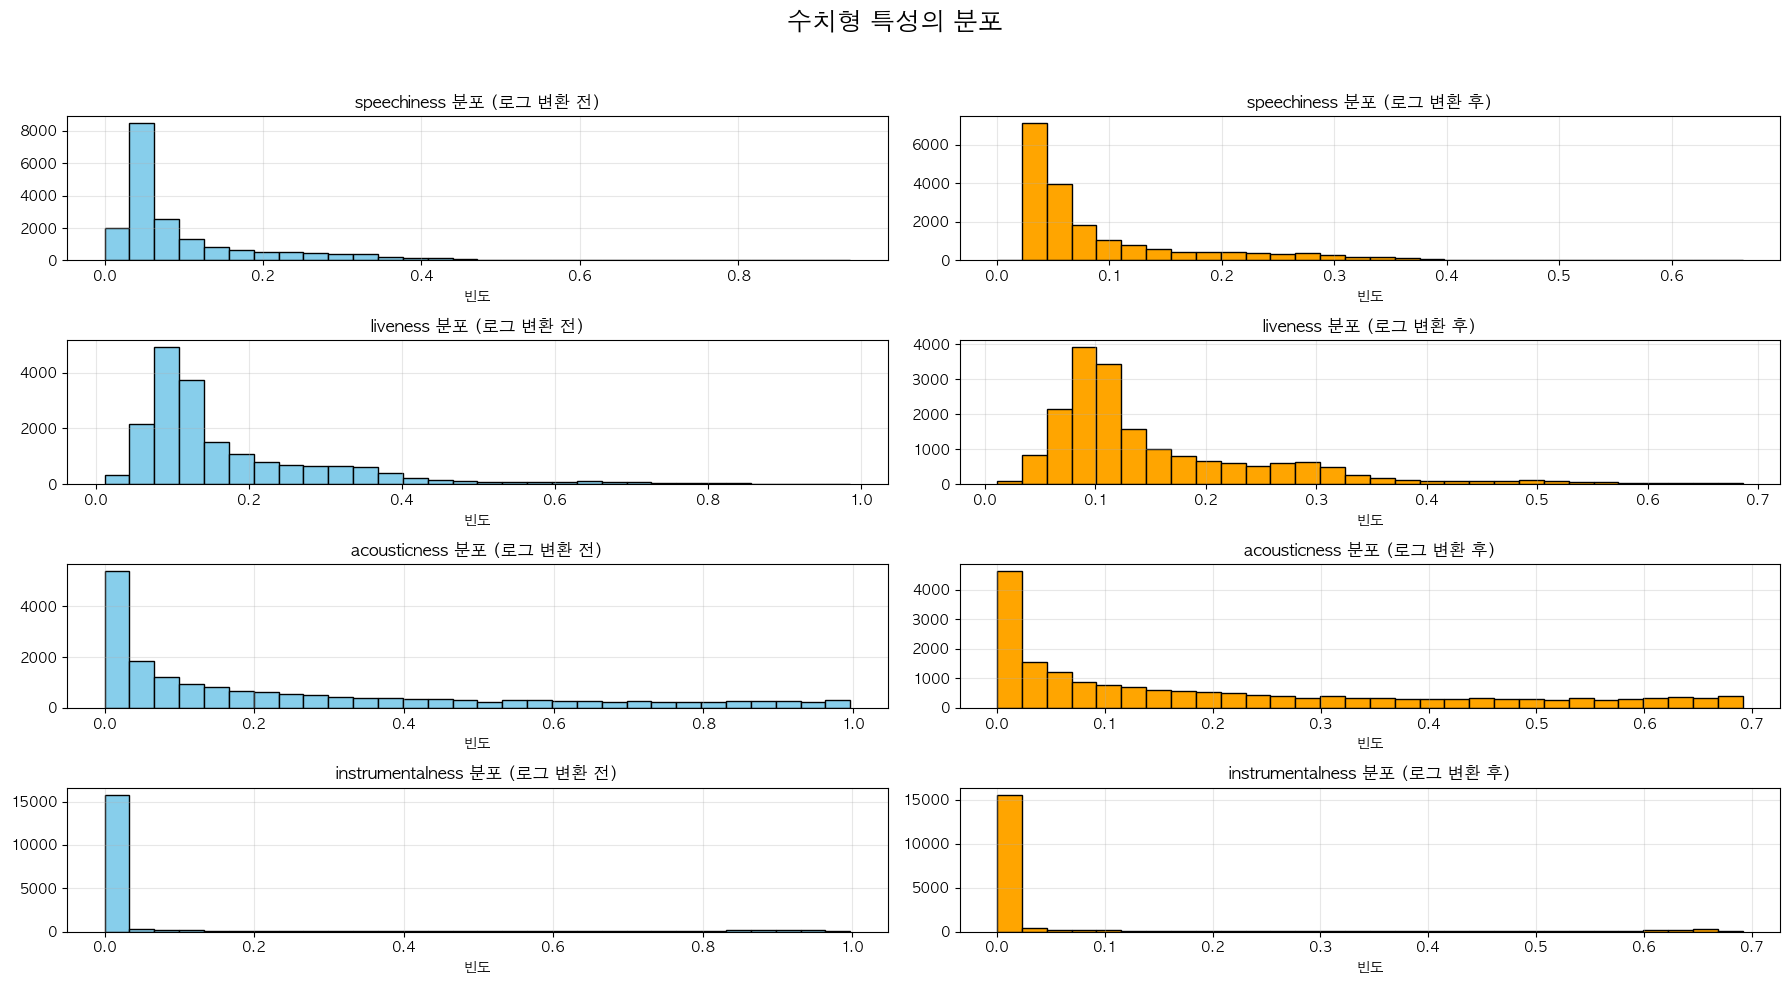

In [17]:
# 보정 전후로 분포 비교
fig, axes = plt.subplots(4, 2, figsize=(18, 10)) # 4행(각 컬럼) 2열(전후) 서브플롯 생성

for idx, col in enumerate(skewed_columns):
    row = idx
    axes[row][0].hist(df[col].dropna(), bins=30, color='skyblue', edgecolor="black") # 로그변환전 분포
    axes[row][0].set_title(f"{col} 분포 (로그 변환 전)")
    axes[row][0].set_xlabel("빈도")
    axes[row][0].grid(alpha=0.3)

    axes[row][1].hist(df_log[col].dropna(), bins=30, color='orange', edgecolor="black") # 로그변환전 분포
    axes[row][1].set_title(f"{col} 분포 (로그 변환 후)")
    axes[row][1].set_xlabel("빈도")
    axes[row][1].grid(alpha=0.3)
    
plt.suptitle("수치형 특성의 분포", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### log1p 적용 후 분포 완화
### 수치로 변환하여 확인

In [18]:
# 왜도(분포의 비대칭성) 값 계산 (0이면 완전 대칭, 0보다 크면 우측 왜도(양의 왜도), 0보다 작으면 좌측 왜도(음의 왜도))
df[skewed_columns].skew() 

speechiness         2.271018
liveness            2.215423
acousticness        1.071164
instrumentalness    2.985176
dtype: float64

### 노래 회귀 예측 모델 구현

In [19]:
# 선형 회귀 모델
from sklearn.linear_model import LinearRegression # 선형 회귀 모델
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # 회귀 성능 평가 지표
from sklearn.model_selection import train_test_split # 데이터셋 분할 함수

X = df[features]  # 입력 변수 (특성)
y = df[target]    # 타겟 변수 (노래 인기도)

# 학습/테스트 데이터셋 분리 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test), len(y_train), len(y_test))

15068 3767 15068 3767


In [20]:
# LinearRegression 모델 학습
lr_model = LinearRegression()
lr_model.fit(X_train, y_train) # 모델 학습

y_pred_lr = lr_model.predict(X_test) # 테스트 데이터 예측

# 학습 데이터 평가 (1000개 데이터만 평가)
print("Train MSE:", mean_squared_error(y_train[:1000], lr_model.predict(X_train[:1000])))
print("Train MAE:", mean_absolute_error(y_train[:1000], lr_model.predict(X_train[:1000])))
print("Train R2:", r2_score(y_train[:1000], lr_model.predict(X_train[:1000])))
print()

# 테스트셋 데이터 평가
print("Test MSE:", mean_squared_error(y_test, y_pred_lr))
print("Test MAE:", mean_absolute_error(y_test, y_pred_lr))
print("Test R2:", r2_score(y_test, y_pred_lr))
print()

Train MSE: 464.14891429373694
Train MAE: 17.340276447810723
Train R2: 0.05481853863575881

Test MSE: 461.6379271397563
Test MAE: 17.055369122574042
Test R2: 0.04239734907577464



### 선형회귀 모델로는 성능이 매우 뒤떨어짐을 확인하였습니다.

### 다른 모델을 사용해봐야겠다.

In [21]:
#다항 회귀 모델 : n차 다항식을 사용하여 비선형 관계를 모델링하는 모델.
#단점으로는 모댈을 차수가 지나치게 높아지면 모델 복잡성이 커져 과적합 가능성이 있는 모델이다.

from sklearn.preprocessing import PolynomialFeatures

degree = 2 # 다항식 특성의 차수
poly = PolynomialFeatures(degree)           #특성을 다항식 특성으로 변환
X_train_poly = poly.fit_transform(X_train)  #학습 데이터 변환
X_test_poly = poly.transform(X_test)        #테스트 데이터 변환

#다항식 특성으로 모델 학습
poly_lr_model = LinearRegression()
poly_lr_model.fit(X_train_poly, y_train)

#예측
y_pred_train = poly_lr_model.predict(X_train_poly) #\
y_pred_test = poly_lr_model.predict(X_test_poly)

print("Train MSE:", mean_squared_error(y_train[:1000], lr_model.predict(X_train[:1000])))
print("Train MAE:", mean_absolute_error(y_train[:1000], lr_model.predict(X_train[:1000])))
print("Train R2 스코어:", r2_score(y_train[:1000], lr_model.predict(X_train[:1000])))
print()

# 테스트셋 데이터 평가
print("MSE:", mean_squared_error(y_test, y_pred_test))
print("MAE:", mean_absolute_error(y_test, y_pred_test))
print("R2 스코어:", r2_score(y_test, y_pred_lr))
print()

Train MSE: 464.14891429373694
Train MAE: 17.340276447810723
Train R2 스코어: 0.05481853863575881

MSE: 448.13435576414804
MAE: 16.733375423036453
R2 스코어: 0.04239734907577464



### 기존 선형 모델보다는 약간 나아진 모습은 있지만, 성능은 낮다.

In [22]:
# Random Forest 회귀 모델 : 여러개의 의사결정 나무를 결합해 비선형적이고 앙상블 기반의 학습을 제공한다.
# 앙상블 사용 -> 과적합에도 강하다.
from sklearn.ensemble import RandomForestRegressor # 랜덤 포레스트 회귀 모델

rf_model = RandomForestRegressor(random_state=42)  # 랜덤 포레스트(앙상블) 모델 생성
rf_model.fit(X_train, y_train)                     # 학습 데이터로 모델 학습

# 예측
y_pred_rf = rf_model.predict(X_test)  # 테스트 데이터로 예측

# 학습 데이터 평가 (1000개만)
print("Train MSE:", mean_squared_error(y_train[:1000], rf_model.predict(X_train[:1000])))
print("Train MAE:", mean_absolute_error(y_train[:1000], rf_model.predict(X_train[:1000])))
print("Train R2 스코어:", r2_score(y_train[:1000], rf_model.predict(X_train[:1000])))
print()

# 테스트셋 데이터 평가
print("MSE:", mean_squared_error(y_test, y_pred_rf))  # 테스트셋 MSE
print("MAE:", mean_absolute_error(y_test, y_pred_rf)) # 테스트셋 MAE
print("R2 스코어:", r2_score(y_test, y_pred_rf))          # 테스트셋 R2 스코어
print()

Train MSE: 45.64990092535656
Train MAE: 4.684875475663226
Train R2 스코어: 0.9070396617572276

MSE: 296.66428068173735
MAE: 12.292303228654694
R2 스코어: 0.384611868059628



### 이전 모델들에 비해서는 향상되었지만, 절대적인 성능은 약간 부족하다.

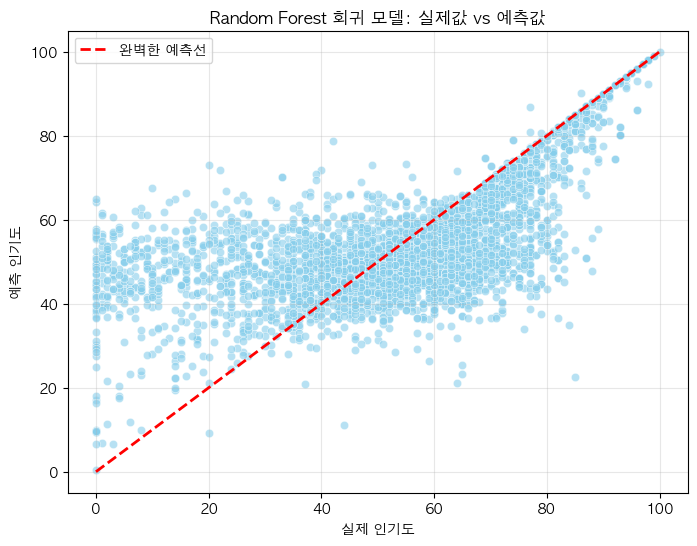

In [23]:
# 성능 시각화 (실제값 vs 예측값)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, color="skyblue", alpha=0.6) # 산점도 : 실제값 vs 예측값
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", linewidth=2, label="완벽한 예측선") # 대각선(완벽한 정답선)
plt.xlabel("실제 인기도")
plt.ylabel("예측 인기도")
plt.title("Random Forest 회귀 모델: 실제값 vs 예측값")
plt.legend()         # 범례
plt.grid(alpha=0.3)  # 격자
plt.show()

### 인기도가 실제 있던 곡들은 그나마 맞추는 편, 인기도가 실제 없었던 곡들은 못맞추는 경향을 보인다.

In [24]:
# Random Forest 모델이 예측할 떄 중요도 분석
importance = rf_model.feature_importances_  # 각 특성의 중요도
feature_names = X.columns  # 특성 이름

feat_df = pd.DataFrame({
    "특성": features, "중요도": importance  # 데이터 프레임 생성
})
feat_df.sort_values("중요도", ascending=False, inplace=True)
feat_df

,특성,중요도
2,danceability,0.101772
12,audio_valence,0.100684
7,loudness,0.099839
4,instrumentalness,0.094501
0,song_duration_ms,0.093604
3,energy,0.093471
1,acousticness,0.092522
10,tempo,0.089712
9,speechiness,0.088082
6,liveness,0.087896


/var/folders/51/k_yn4qxs0_nfrm1hk39_0m2r0000gn/T/ipykernel_31944/2481810510.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="중요도", y= "특성", data=feat_df.head(10), palette='viridis') #상위 10개 특성 중요도 bar 플롯


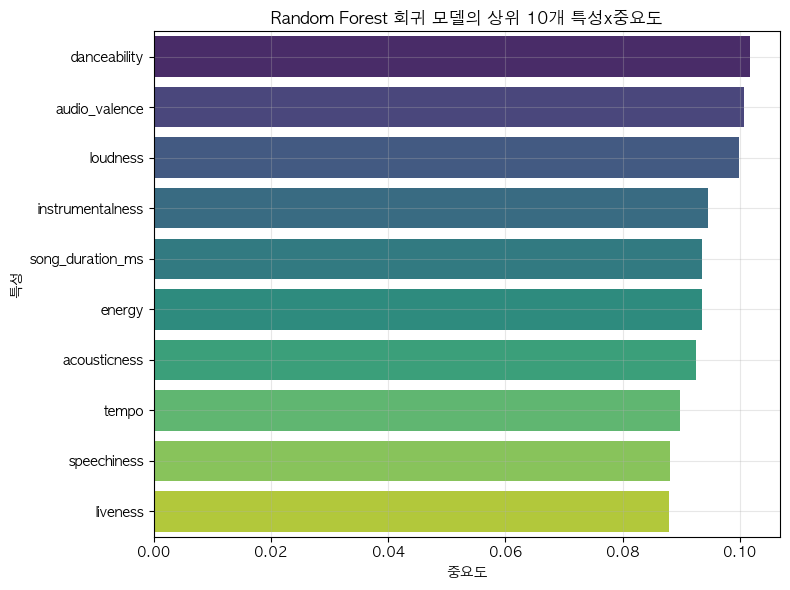

In [25]:
# 성능 시각화 (실제값 VS 예측값)
plt.figure(figsize=(8, 6))
sns.barplot(x="중요도", y= "특성", data=feat_df.head(10), palette='viridis') #상위 10개 특성 중요도 bar 플롯
plt.xlabel("중요도")
plt.ylabel("특성")
plt.title("Random Forest 회귀 모델의 상위 10개 특성x중요도")
plt.tight_layout()
plt.grid(alpha=0.3)
plt.show()

#### 1. 상위 3개를 확인했을 때 특성의 중요도가 0.1 정도로 매우 낮다.
#### 2. 인기도는 특성만으로 뽑기가 좀 애매한 면이 있어 주관적인 사항도 같이 특성으로 반영을 해주면 더 좋은 결과를 얻을수도 있다.

### 회귀모델 고도화
GridSearchCV를 사용해서 Random Forest 모델을 고도화하려고 한다.   
n_estimators : 트리의 갯수 (기본값 100)   
max_depth : 트리의 최대 깊이 (기본값 None: 모든 리프 노드가 가장 순수해질 떄까지 나무 성장)   
min_samples_split : 내부 노드 분할을 위해 필요한 최소 샘플 수 (기본값 2)   
min_samples_leaf : 리프 노드를 위한 최소 샘플 수 (기본값 1)   
max_features : 특성의 최대 개수 (기본값 'auto')   
bootstrap : 랜덤 포레스트에서 사용할 샘플링 방법 (기본값 True)

하이퍼파라미터 튜닝 도구는 GridSearchCV 말고도 Optuna가 있습니다.

In [26]:
from sklearn.model_selection import GridSearchCV # 하이퍼파라미터 튜닝 도구

param_grid = {
    "n_estimators": [100, 200],           # 트리 갯수
    "max_depth": [None, 10, 20],          # 트리 깊이
    "min_samples_split": [2, 5],          # 내부 노드 분할을 위한 최소 샘플 수
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    rf,                                      # 최적 파라미터를 뽑아낼 모델
    param_grid,                              # 최적 파라미터를 테스트할 값
    cv = 5,                                  # 5-fold 교차 검증
    scoring = "neg_mean_squared_error",      # 성능 평가 지표: 평균제곱오차 MSE
    n_jobs = -1,                             # 모든 CPU 사용(병렬)
    verbose = 2                              # 진행상황 출력
)

grid_search.fit(X_train, y_train) # 하이퍼파라미터 튜닝(모델 학습)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   9.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   9.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   9.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   9.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   9.3s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   8.2s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   8.5s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   8.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  18.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  18.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  18.5s
[CV] END max_depth=None, m

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestR...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [None, 10, ...], 'min_samples_split': [2, 5], 'n_estimators': [100, 200]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is di

In [27]:
best_rf = grid_search.best_estimator_              # 최적의 하이퍼파라미터로 학습된 Random Forest 모델
print(f"최고의 설정값은? {grid_search.best_params_}")  # 파라미터로 조합중 가장 성능이 좋은 조합 출력

최고의 설정값은? {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


#### 최고의 설정값
    - 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200
    - 이걸로 Random Forest모델을 다시 학습을 시키고 결과를 확인해 봐야 한다.


In [28]:
# 최적의 설정값으로 나온 트리 개수만 200개로 추가 설정
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)

# 학습데이터로 모델 학습
rf_model.fit(X_train, y_train)

# 예측
y_pred_rf = rf_model.predict(X_test)  # 테스트셋 예측

# 학습 데이터 평가 (1000개만)
print("Train MSE:", mean_squared_error(y_train[:1000], rf_model.predict(X_train[:1000])))
print("Train MAE:", mean_absolute_error(y_train[:1000], rf_model.predict(X_train[:1000])))
print("Train R2 스코어:", r2_score(y_train[:1000], rf_model.predict(X_train[:1000])))
print()

# 테스트셋 데이터 평가
print("MSE:", mean_squared_error(y_test, y_pred_rf))  # 테스트셋 MSE
print("MAE:", mean_absolute_error(y_test, y_pred_rf)) # 테스트셋 MAE
print("R2 스코어:", r2_score(y_test, y_pred_rf))          # 테스트셋 R2 스코어
print()


Train MSE: 43.42824897084544
Train MAE: 4.59032351973027
Train R2 스코어: 0.9115637792900733

MSE: 293.62138415614527
MAE: 12.200113548992801
R2 스코어: 0.3909239269440641



#### R2 스코어 기준 0.40 -> 0.41로 소폭 상승

# 모델 변경 (Boosting 계열)
- XGBoost: 약한 모델에서부터 순차적으로 트리를 추가하는 방식의 그래디언트 부스팅 알고리즘. 높은 정확도와 유연성
- LightGBM: 더 빠르고 효율적인 그래디언트 부스팅 알고리즘. 내부적으로 히스토그램 기반의 불할 방식과 리프 중심 트리 성장 전략을 사용한다.

In [31]:
from xgboost import XGBRegressor

xgb_param_grid = {
    "n_estimators": [100, 200],   # 트리 갯수
    "max_depth": [None, 10, 20],  # 트리 최대 깊이
    "learning_rate": [0.1, 0.01], # 학습률 (클수록 빠른 학습, 불안정성 증가)
    "min_child_weight": [1, 2]    # 리프노드 최소 가중치
}

xgb_model = XGBRegressor(random_state=42)

xgb_grid_search = GridSearchCV(
    xgb_model,
    xgb_param_grid,
    cv = 5,           # 5-fold 교차검증
    scoring = "neg_mean_squared_error", # 성능평가지표: 평균제곱오차 MSE
    n_jobs = -1,
    verbose = 2
)

xgb_grid_search.fit(X_train, y_train) # 하이퍼파라미터 튜닝 학습
xgb_model = xgb_grid_search.best_estimator_ # 최적의 XGBoost 모델

xgb_model.fit(X_train, y_train) # 최적의 모델로 학습


y_pred = xgb_model.predict(X_test) # 테스트 데이터 예측

# 평가
xgb_mse_test = mean_squared_error(y_test, y_pred)
xgb_mae_test = mean_absolute_error(y_test, y_pred)
xgb_r2_test = r2_score(y_test, y_pred)

# 출력
print("XGBoost MSE :", xgb_mse_test)
print("XGBoost MAE :", xgb_mae_test)
print("XGBoost R2 :", xgb_r2_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END learning_rate=0.1, max_depth=None, min_child_weight=1, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=None, min_child_weight=1, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=None, min_child_weight=1, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=None, min_child_weight=1, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=None, min_child_weight=1, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=None, min_child_weight=1, n_estimators=200; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=None, min_child_weight=1, n_estimators=200; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=None, min_child_weight=1, n_estimators=200; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=None, min_child_weight=2, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.1, m

/opt/anaconda3/envs/ml_env/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END learning_rate=0.01, max_depth=20, min_child_weight=2, n_estimators=100; total time=  21.2s
[CV] END learning_rate=0.01, max_depth=20, min_child_weight=2, n_estimators=100; total time=  21.9s
[CV] END learning_rate=0.01, max_depth=20, min_child_weight=1, n_estimators=200; total time=  57.5s
[CV] END learning_rate=0.01, max_depth=20, min_child_weight=1, n_estimators=200; total time=  59.9s
[CV] END learning_rate=0.01, max_depth=20, min_child_weight=2, n_estimators=200; total time=  50.1s
[CV] END learning_rate=0.01, max_depth=20, min_child_weight=2, n_estimators=200; total time=  50.3s
[CV] END learning_rate=0.01, max_depth=20, min_child_weight=2, n_estimators=200; total time=  48.2s
[CV] END learning_rate=0.01, max_depth=20, min_child_weight=2, n_estimators=200; total time=  48.3s
[CV] END learning_rate=0.01, max_depth=20, min_child_weight=2, n_estimators=200; total time=  43.9s
XGBoost MSE : 311.2313537597656
XGBoost MAE : 12.17602825164795
XGBoost R2 : 0.3543945550918579


In [ ]:
from lightgbm import LGBMRegressor

lgbm_model = LGBMRegressor(
    n_estimators=100,    # 트리의 개수
    max_depth=1,         # 트리의 최대 깊이
    learning_rate=0.1,   # 학습률
    num_leaves = 100     # 하나의 트리에서 가질수있는 최대 잎사귀 수
)

lgbm_model = XGBRegressor(random_state=42)

lgbm_grid_search = GridSearchCV(
    lgbm_model,
    lgbm_param_grid,
    cv = 5,           # 5-fold 교차검증
    scoring = "neg_mean_squared_error", # 성능평가지표: 평균제곱오차 MSE
    n_jobs = -1,
    verbose = 2
)

lgbm_grid_search.fit(X_train, y_train) # 하이퍼파라미터 튜닝 학습
lgbm_model = lgbm_grid_search.best_estimator_ # 최적의 XGBoost 모델

lgbm_model.fit(X_train, y_train) # 최적의 모델로 학습


y_pred = lgbm_model.predict(X_test) # 테스트 데이터 예측

# 평가
lgbm_mse_test = mean_squared_error(y_test, y_pred)
lgbm_mae_test = mean_absolute_error(y_test, y_pred)
lgbm_r2_test = r2_score(y_test, y_pred)

# 출력
print("LightGBM MSE :", lgbm_mse_test)
print("LightGBM MAE :", lgbm_mae_test)
print("LightGBM R2 :", lgbm_r2_test)




### 가장 성능이 좋았던 것은 GridSearchCV를 사용해 최적의 파라미터를 구해서 사용한 RandomForest모델이었다.   여기서 성능을 더 높이고 싶다면
- GridSearchCV의 테스트 파라미터를 더 늘려서 해보거나 (RF, XGB)
- 데이터를 다른 데이터로 변경